In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
def make_df(filename: str):
    df  = pd.read_csv(filename)
    df.loc[:, "nspecies"] = 1
    df.loc[df.model.isin(["00030", "00031"]), "nspecies"] = 2
    df.loc[:, "ntest"] = df.nspecies * 100
    df.loc[:, "total_pass"] = df.ntest - (df["test0"] + df["test1"] + df["test2"] + df["test3"])
    df.loc[df["total_pass"] > df.ntest, "total_pass"] = 0
    return df

In [20]:
pyssa_results = make_df("../results/pyssa_results.csv")
tellurium_results = make_df("../results/Tellurium_results.csv")
biosimulator_results = make_df("../results/BioSimulator_results.csv")
gillespiessa_results = make_df("../results/GillespieSSA_results.csv")

In [22]:
results = pd.concat([pyssa_results, tellurium_results, biosimulator_results, gillespiessa_results])
results

,model,lib,algo,nrep,test0,test1,test2,test3,nspecies,ntest,total_pass
0,1,pyssa,direct,10000,0,0,0,0,1,100,100
1,1,pyssa,tau_leaping,10000,0,0,0,0,1,100,100
2,1,pyssa,tau_adaptive,10000,0,0,0,0,1,100,100
3,3,pyssa,direct,10000,0,0,0,7,1,100,93
4,3,pyssa,tau_leaping,10000,0,0,8,0,1,100,92
...,...,...,...,...,...,...,...,...,...,...,...
23,37,GillespieSSA,tau_adaptive,10000,50,0,50,0,1,100,0
24,38,GillespieSSA,tau_leaping,10000,50,0,50,0,1,100,0
25,38,GillespieSSA,tau_adaptive,10000,50,0,50,0,1,100,0
26,39,GillespieSSA,tau_leaping,10000,50,0,50,0,1,100,0


In [39]:
# TODO: Make it easy to distinguish between pass and fail
def plot_pass_bars(df, hue="algo"):
    plt.figure(figsize=(14,5))
    g = sns.barplot(x="model", y="total_pass", hue=hue, data=df)
    for p in g.patches:
        if np.isnan(p.get_height()):
            continue
        height = int(p.get_height())
        if height == 100:
            color = "green"
        else:
            color = "red"
        g.annotate(f"{height}", (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', fontsize=8, color=color, xytext=(0, 10),
        textcoords='offset points')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
    plt.ylim(0,120)
#     plt.axhline(200)

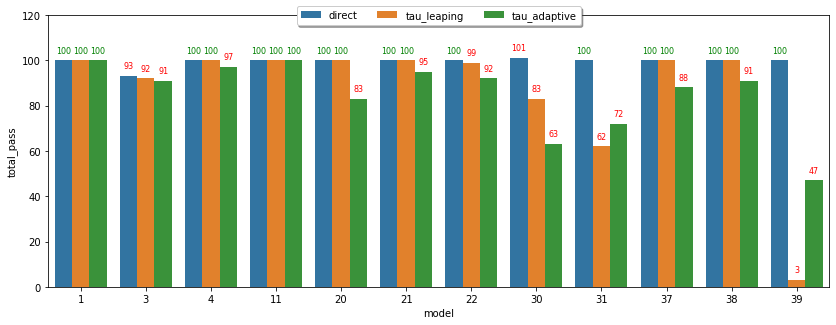

In [32]:
plot_pass_bars(results[results.lib == "pyssa"])

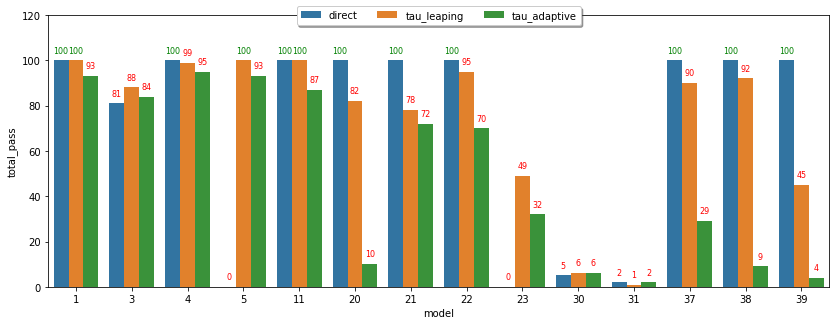

In [28]:
plot_pass_bars(results[results.lib == "BioSimulator"])

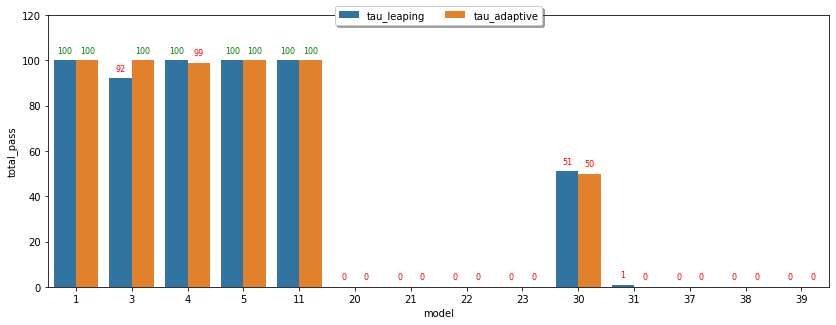

In [29]:
plot_pass_bars(results[results.lib == "GillespieSSA"]) # tau = 0.1

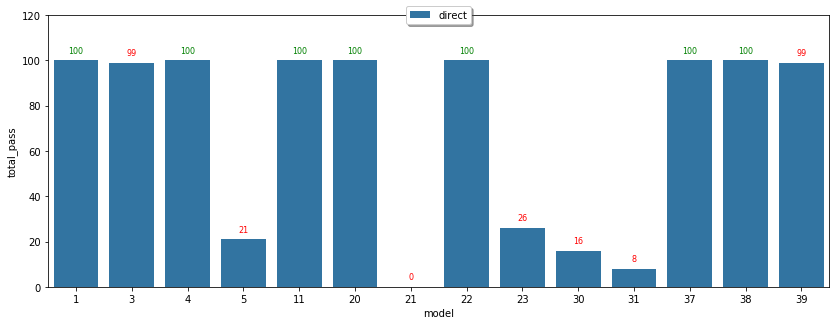

In [30]:
plot_pass_bars(results[results.lib == "Tellurium"])

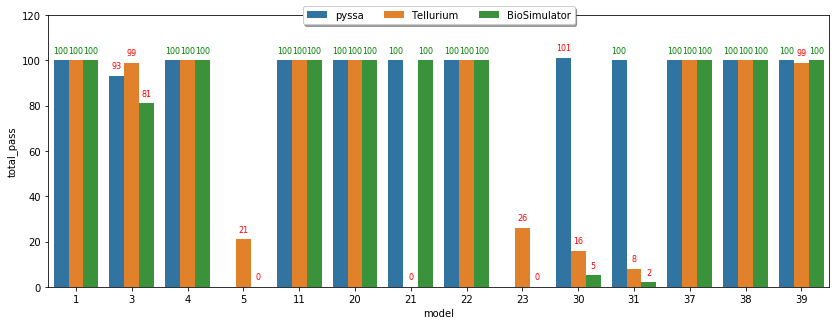

In [40]:
plot_pass_bars(results[results.algo == "direct"], hue="lib")

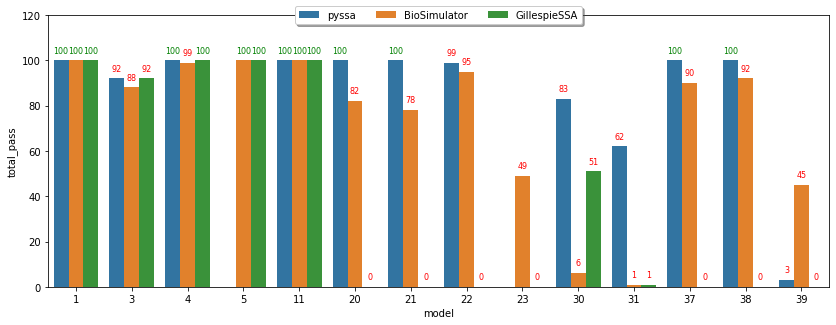

In [43]:
plot_pass_bars(results[results.algo == "tau_leaping"], hue="lib")

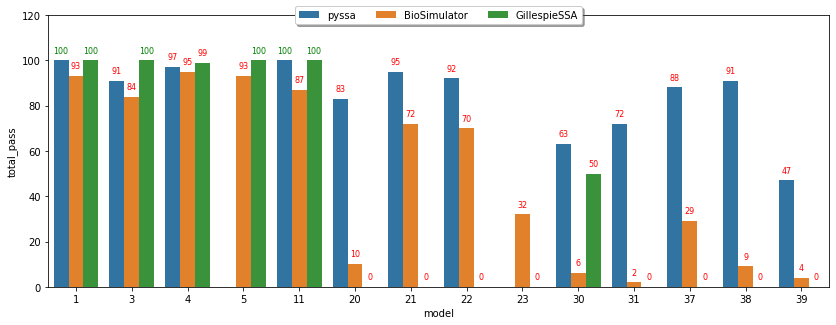

In [44]:
plot_pass_bars(results[results.algo == "tau_adaptive"], hue="lib")